In [1]:
import pandas as pd
import numpy as np
import pandas as pd
from time import time

from keras.models import Model, Input, load_model #model_from_json
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers
#from keras.optimizer_v2 import rmsprop
from keras import optimizers
#from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import StratifiedKFold

import keras.backend as K
from keras.layers import multiply
from keras.layers.core import Dense, Reshape, Lambda, RepeatVector, Permute, Flatten


In [2]:
import lstm_preprocess

## Read the data

In [3]:
data = pd.read_csv("C:\\Users\\Maria\\Desktop\\data\\icd_demos_vitals.csv")

In [4]:
data.drop("Unnamed: 0", axis=1, inplace=True)

## Preprocess

1. padding
2. remove unnesecary columns
3. bring to the (samples, timesteps, features) format 
4. Split train, test, validation 
5. Z-normalization using mean and std from train set

## 1. padding

In [5]:
#either keep the patients with 24 hours of admission, or change 23 to sth smaller to include patients with less time steps
df = lstm_preprocess.pad(data, 23, 24, 0)

In [6]:
target = df[["subject_id", "hadm_id", "mortality"]]

In [7]:
target

,subject_id,hadm_id,mortality
0,11728.0,100061.0,1.0
1,11728.0,100061.0,1.0
2,11728.0,100061.0,1.0
3,11728.0,100061.0,1.0
4,11728.0,100061.0,1.0
...,...,...,...
53131,55617.0,199984.0,0.0
53132,55617.0,199984.0,0.0
53133,55617.0,199984.0,0.0
53134,55617.0,199984.0,0.0


In [8]:
print('There are {0} rows in the df after padding'.format(len(df)))

There are 53136 rows in the df after padding


### here i am just doing some checks to see how many time steps a patient has 

In [9]:
x = df.hadm_id.value_counts() == 23


In [10]:
x[x.values == True]

Series([], Name: hadm_id, dtype: bool)

In [11]:
df[df.hadm_id == 196831]

,hadm_id,subject_id,mortality,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+


In [12]:
data[data.hadm_id == 196831]

,hadm_id,subject_id,mortality,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,SpO2,...,18,19,20,F,M,18-25,25-45,45-65,65-89,89+
81053,196831,2372.0,0.0,105.000000,136.333333,54.666667,75.000000,13.000000,0.000000,100.0,...,1,0,1,0,1,1,0,0,0,0
81054,196831,2372.0,0.0,82.333333,144.000000,62.666667,80.666667,14.333333,37.333332,100.0,...,1,0,1,0,1,1,0,0,0,0
81055,196831,2372.0,0.0,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,100.0,...,1,0,1,0,1,1,0,0,0,0
81056,196831,2372.0,0.0,87.500000,131.500000,64.000000,79.500000,12.000000,37.222222,100.0,...,1,0,1,0,1,1,0,0,0,0
81057,196831,2372.0,0.0,93.000000,121.500000,56.000000,76.166649,12.000000,0.000000,100.0,...,1,0,1,0,1,1,0,0,0,0
81058,196831,2372.0,0.0,91.000000,116.500000,65.500000,80.500000,12.000000,0.000000,99.0,...,1,0,1,0,1,1,0,0,0,0
81059,196831,2372.0,0.0,97.000000,109.000000,61.500000,76.500000,12.000000,0.000000,99.0,...,1,0,1,0,1,1,0,0,0,0
81060,196831,2372.0,0.0,91.000000,119.000000,64.500000,82.000000,12.000000,37.500000,100.0,...,1,0,1,0,1,1,0,0,0,0
81061,196831,2372.0,0.0,94.000000,110.500000,56.000000,73.166649,12.000000,0.000000,99.0,...,1,0,1,0,1,1,0,0,0,0


## 2. remove columns  

In [13]:
#remove unnecessary columns
COLUMNS = lstm_preprocess.delete_columns(df)

In [14]:
COLUMNS

['HeartRate',
 'SysBP',
 'DiasBP',
 'MeanBP',
 'RespRate',
 'TempC',
 'SpO2',
 'Glucose',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 'F',
 'M',
 '18-25',
 '25-45',
 '45-65',
 '65-89',
 '89+']

In [15]:
df.hadm_id.value_counts()

138921.0    24
146105.0    24
189378.0    24
142407.0    24
183558.0    24
            ..
108935.0    24
141092.0    24
172683.0    24
139035.0    24
157802.0    24
Name: hadm_id, Length: 2214, dtype: int64

## 3. reshape the matrix to the appropriate format

In [16]:


MATRIX = df[COLUMNS+['mortality']].values
MATRIX = MATRIX.reshape(int(MATRIX.shape[0]/24),24,MATRIX.shape[1])

## 4. Split train, test, validation

In [17]:

bool_matrix = (~MATRIX.any(axis=2))
MATRIX[bool_matrix] = np.nan
#MATRIX = lstm_preprocess.ZScoreNormalize(MATRIX)

## restore 3D shape to boolmatrix for consistency
bool_matrix = np.isnan(MATRIX)
MATRIX[bool_matrix] = 0 
   
#permutation = np.random.permutation(MATRIX.shape[0])
#MATRIX = MATRIX[permutation]
#bool_matrix = bool_matrix[permutation]

X_MATRIX = MATRIX[:,:,0:-7]
Y_MATRIX = MATRIX[:,:,-1]
#x_bool_matrix = bool_matrix[:,:,0:-1]
#y_bool_matrix = bool_matrix[:,:,-1]

In [18]:
np.isnan(X_MATRIX).any()

False

In [19]:
#train, validation, test split

tt_split = 0.7 
val_percentage = 0.8

X_TRAIN = X_MATRIX[0:int(tt_split*X_MATRIX.shape[0]),:,:]
Y_TRAIN = Y_MATRIX[0:int(tt_split*Y_MATRIX.shape[0]),:]
Y_TRAIN = Y_TRAIN[:, 0] 
Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], 1)
#Y_TRAIN = Y_TRAIN.reshape(Y_TRAIN.shape[0], Y_TRAIN.shape[1], 1)

X_VAL = X_MATRIX[int(tt_split*X_MATRIX.shape[0]):int(val_percentage*X_MATRIX.shape[0])]
Y_VAL = Y_MATRIX[int(tt_split*Y_MATRIX.shape[0]):int(val_percentage*Y_MATRIX.shape[0])]
Y_VAL = Y_VAL[:, 0] 
Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], 1)
#Y_VAL = Y_VAL.reshape(Y_VAL.shape[0], Y_VAL.shape[1], 1)
"""
x_val_boolmat = x_bool_matrix[int(tt_split*x_bool_matrix.shape[0]):int(val_percentage*x_bool_matrix.shape[0])]
y_val_boolmat = y_bool_matrix[int(tt_split*y_bool_matrix.shape[0]):int(val_percentage*y_bool_matrix.shape[0])]
y_val_boolmat = y_val_boolmat.reshape(y_val_boolmat.shape[0],y_val_boolmat.shape[1],1)
"""
X_TEST = X_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_MATRIX[int(val_percentage*X_MATRIX.shape[0])::]
Y_TEST = Y_TEST[:, 0] 
Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], 1)
#Y_TEST = Y_TEST.reshape(Y_TEST.shape[0], Y_TEST.shape[1], 1)
"""
x_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]
y_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]
y_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)

X_TEST[x_test_boolmat] = 0
Y_TEST[y_test_boolmat] = 0
"""

'\nx_test_boolmat = x_bool_matrix[int(val_percentage*x_bool_matrix.shape[0])::]\ny_test_boolmat = y_bool_matrix[int(val_percentage*y_bool_matrix.shape[0])::]\ny_test_boolmat = y_test_boolmat.reshape(y_test_boolmat.shape[0],y_test_boolmat.shape[1],1)\n\nX_TEST[x_test_boolmat] = 0\nY_TEST[y_test_boolmat] = 0\n'

## 5. Normalize

In [20]:
X_TRAIN, X_VAL, X_TEST = lstm_preprocess.normalize(X_TRAIN, X_TEST, X_VAL)


Shape should be dx1:  (29,)
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\data_extraction\lstm_preprocess.py:76: RuntimeWarning: invalid value encountered in true_divide
  train /= train_std
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\data_extraction\lstm_preprocess.py:79: RuntimeWarning: invalid value encountered in true_divide
  val /= train_std
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\data_extraction\lstm_preprocess.py:82: RuntimeWarning: invalid value encountered in true_divide
  test /= train_std


In [21]:
X_TRAIN.shape

(1549, 24, 29)

In [22]:
no_feature_cols = X_TRAIN.shape[2]


In [23]:
np.isnan(Y_TRAIN).any()


False

In [24]:
bool_matrix = np.isnan(X_VAL)
X_VAL[bool_matrix] = 0 
np.isnan(X_VAL).any()

False

In [25]:
bool_matrix = np.isnan(X_TRAIN)
X_TRAIN[bool_matrix] = 0 
np.isnan(X_TRAIN).any()

False

In [26]:
bool_matrix = np.isnan(X_TEST)
X_TEST[bool_matrix] = 0 
np.isnan(X_TEST).any()

False

## A simple LSTM

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import tensorflow
from tensorflow import keras
from tensorflow.keras import layers


from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=24, output_summary=False):
  
  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  
  model = keras.Sequential()
  model.add(layers.LSTM(4, input_shape = (time_steps, no_feature_cols)))
  model.add(layers.Dense(1, activation="sigmoid"))
  optimizer = tensorflow.keras.optimizers.RMSprop()
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model



In [28]:
Y_TRAIN.shape

(1549, 1)

In [29]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)

time_steps:24|no_feature_cols:29
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 544       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 549
Trainable params: 549
Non-trainable params: 0
_________________________________________________________________


In [30]:
  #init callbacks
  tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "./saved_models/{0}".format('model_name')

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
history_reg = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

Epoch 1/100
97/97 [==============================] - 4s 20ms/step - loss: 0.6446 - acc: 0.6398 - val_loss: 0.6025 - val_acc: 0.6757
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 0.5513 - acc: 0.7463 - val_loss: 0.5372 - val_acc: 0.7523
Epoch 3/100
97/97 [==============================] - 1s 7ms/step - loss: 0.4940 - acc: 0.7824 - val_loss: 0.4994 - val_acc: 0.7658
Epoch 4/100
97/97 [==============================] - 1s 6ms/step - loss: 0.4653 - acc: 0.8005 - val_loss: 0.4806 - val_acc: 0.7838
Epoch 5/100
97/97 [==============================] - 1s 7ms/step - loss: 0.4494 - acc: 0.8115 - val_loss: 0.4714 - val_acc: 0.7928
Epoch 6/100
97/97 [==============================] - 1s 7ms/step - loss: 0.4396 - acc: 0.8167 - val_loss: 0.4677 - val_acc: 0.7883
Epoch 7/100
97/97 [==============================] - 1s 8ms/step - loss: 0.4317 - acc: 0.8192 - val_loss: 0.4646 - val_acc: 0.7973
Epoch 8/100
97/97 [==============================] - 1s 8ms/step - loss: 0.4244 - 

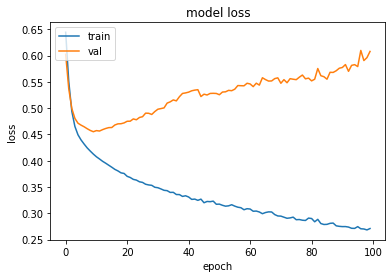

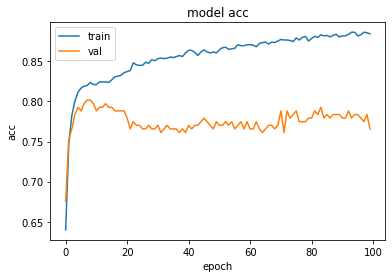

In [44]:
import matplotlib.pyplot as plt  

plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

plt.plot(history_reg.history['acc'])
plt.plot(history_reg.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


In [45]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED, (Y_PRED.shape[0],  Y_PRED.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
# #print(confusion_matrix(val, pred))
print('Validation Accuracy')
print(accuracy_score(val, np.around(pred)))
print('ROC AUC SCORE VAL')
print(roc_auc_score(val, pred))

TARGET: mortality
Validation Accuracy
0.7792792792792793
ROC AUC SCORE VAL
0.6848122645186435


## Adding regularization

In [46]:
def build_model(no_feature_cols=None, time_steps=7, output_summary=False):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 

  model = keras.Sequential()
  model.add(layers.LSTM(4, return_sequences=False, input_shape = (time_steps, no_feature_cols), bias_regularizer= regularizers.L1L2(l1=0.01, l2=0.01)) )
  model.add(layers.Dense(1, activation="sigmoid"))
  opt = tensorflow.keras.optimizers.RMSprop()
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model


  
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 




#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

time_steps:24|no_feature_cols:29
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 4)                 544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 549
Trainable params: 549
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
97/97 [==============================] - 5s 37ms/step - loss: 0.7520 - acc: 0.6198 - val_loss: 0.7204 - val_acc: 0.6486
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 0.6542 - acc: 0.7301 - val_loss: 0.6470 - val_acc: 0.7432
Epoch 3/100
97/97 [==============================] - 1s 7ms/step - loss: 0.5903 - acc: 0.7850 - val_loss: 0.5960 - val_acc: 0.7838
Epoch 4/100
97/97 [==============================] - 1s 6ms/step - loss: 0.5468 - acc: 0.80

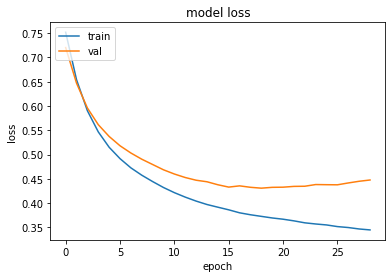

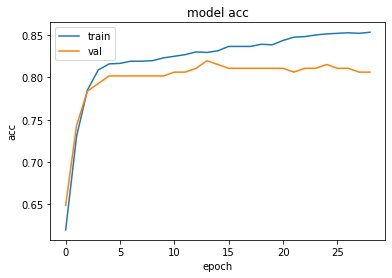

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


In [48]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED, (Y_PRED.shape[0],  Y_PRED.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
# #print(confusion_matrix(val, pred))
print('Validation Accuracy')
print(accuracy_score(val, np.around(pred)))
print('ROC AUC SCORE VAL')
print(roc_auc_score(val, pred))

TARGET: mortality
Validation Accuracy
0.8063063063063063
ROC AUC SCORE VAL
0.7369104846043913


## Add drop out and adjust learning rate

In [58]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=24, output_summary=False):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 

  model = keras.Sequential()
  model.add(layers.LSTM(4, return_sequences=False, input_shape = (time_steps, no_feature_cols), dropout=0.6,bias_regularizer= regularizers.L1L2(l1=0.01, l2=0.01)))
  #model.add(BatchNormalization())
  model.add(layers.Dense(1, activation="sigmoid"))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, time_steps=24)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

time_steps:24|no_feature_cols:29
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 4)                 544       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
Total params: 549
Trainable params: 549
Non-trainable params: 0
_________________________________________________________________
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\.venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
97/97 [==============================] - 6s 38ms/step - loss: 0.7195 - acc: 0.6746 - val_loss: 0.6965 - val_acc: 0.6532
Epoch 2/100
97/97 [==============================] - 1s 7ms/step - loss: 0.6491 - acc: 0.7773 - val_loss: 0.632

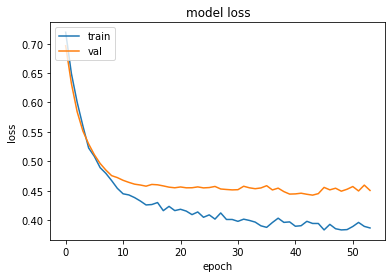

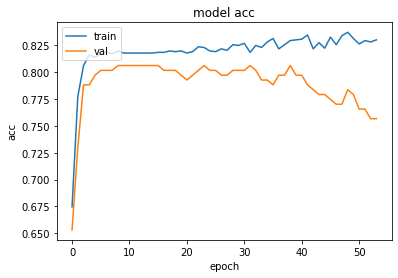

In [59]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [60]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_TRAIN, (Y_TRAIN.shape[0],  Y_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
print(confusion_matrix(train, np.around(pred)))
print('TEST SET Accuracy')
print(accuracy_score(train, np.around(pred)))
print('ROC AUC SCORE TEST SET')
print(roc_auc_score(train, np.around(pred)))

TARGET: mortality
[[1139  128]
 [ 155  127]]
TEST SET Accuracy
0.8173014848289218
ROC AUC SCORE TEST SET
0.6746642820758255


## Add Batch Normalization

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import BatchNormalization
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers

#from tensorflow.keras import optimizers

from tensorflow.keras.optimizers import RMSprop

def build_model1(no_feature_cols=None, time_steps=24, output_summary=False):
  

  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 

  model = keras.Sequential()
  model.add(layers.LSTM(4, return_sequences=False, input_shape = (time_steps, no_feature_cols), dropout=0.5,bias_regularizer= regularizers.L1L2(l1=0.01, l2=0.01)))
  model.add(BatchNormalization())
  model.add(layers.Dense(1, activation="sigmoid"))
  optimizer = tensorflow.keras.optimizers.RMSprop(lr=0.001, epsilon=1e-08)
  model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model1(no_feature_cols=no_feature_cols, output_summary=True, time_steps=24)
#init callbacks
tb_callback = TensorBoard(log_dir='.\\logs\\{0}.log'.format('LSTM_reg'),
histogram_freq=0,
write_grads=False,
write_images=True,
write_graph=True) 

#early stopping
callback_early = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
  #Make checkpoint dir and init checkpointer
checkpoint_dir = "./saved_models/{0}".format('model_name')

if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)


#fit
history = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    callbacks=[tb_callback, callback_early], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)

time_steps:24|no_feature_cols:29
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 4)                 544       
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 4)                 16        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 565
Trainable params: 557
Non-trainable params: 8
_________________________________________________________________
c:\Users\Maria\Desktop\Projects Data Scripts\KTH_PROJECT_MIMIC_2021\.venv\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
Epoch 1/100
97/97 [==============================] - 6s 40ms/step - loss: 0.8758 - acc: 0.5216 - val_loss: 0.69

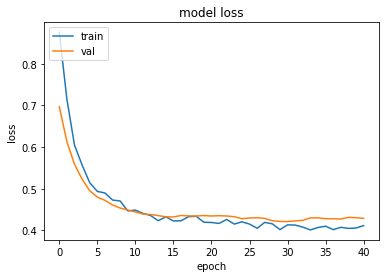

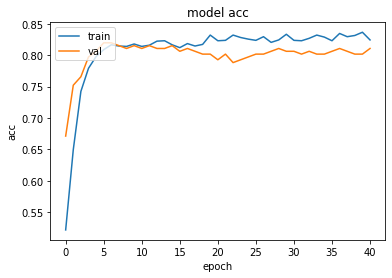

In [79]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show();


plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [80]:
print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_TRAIN, (Y_TRAIN.shape[0],  Y_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
print(confusion_matrix(train, np.around(pred)))
print('TEST SET Accuracy')
print(accuracy_score(train, np.around(pred)))
print('ROC AUC SCORE TEST SET')
print(roc_auc_score(train, np.around(pred)))

TARGET: mortality
[[1195   72]
 [ 185   97]]
TEST SET Accuracy
0.8340865074241446
ROC AUC SCORE TEST SET
0.6435722402279355


## Model with Attention (got it from the 1st paper on our reference list so i need to double check it as i just copy pasted it)

In [81]:
def Attention(inputs, TIME_STEPS):
    """
    inputs.shape = (batch_size, time_steps, input_dim)
    """ 
    input_dim = int(inputs.shape[2])
    a = Permute((2, 1))(inputs)
    a = Reshape((input_dim, TIME_STEPS))(a)
    a = Dense(TIME_STEPS, activation='softmax')(a)
    a_probs = Permute((2, 1), name='attention_vec')(a)
    #output_attention_mul = merge([inputs, a_probs], name='attention_mul', mode='mul')
    output_attention_mul = multiply([inputs, a_probs])
    return output_attention_mul

In [ ]:
def build_model(no_feature_cols=None, time_steps=7, output_summary=False):
  
  """
  Assembles RNN with input from return_data function
  Args:
  ----
  no_feature_cols : The number of features being used AKA matrix rank
  time_steps : The number of days in a time block
  output_summary : Defaults to False on returning model summary
  Returns:
  ------- 
  Keras model object
  """
  print("time_steps:{0}|no_feature_cols:{1}".format(time_steps,no_feature_cols)) 
  input_layer = Input(shape=(time_steps, no_feature_cols)) 
  x = Attention(input_layer, time_steps)
  x = Masking(mask_value=0, input_shape=(time_steps, no_feature_cols))(x) 
  x = LSTM(256, return_sequences=True)(x)
  preds = TimeDistributed(Dense(1, activation="sigmoid"))(x)
  model = Model(inputs=input_layer, outputs=preds)
  #opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
  #RMS = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
  model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])
  
  if output_summary:
    model.summary()
  return model


In [ ]:
no_feature_cols = X_TRAIN.shape[2]
#build model
model = build_model(no_feature_cols=no_feature_cols, output_summary=True, 
                      time_steps=24)

In [ ]:
  #init callbacks
  tb_callback = TensorBoard(log_dir='./logs/{0}_{1}.log'.format('model_name', time),
    histogram_freq=0,
    write_grads=False,
    write_images=True,
    write_graph=True) 

  #Make checkpoint dir and init checkpointer
  checkpoint_dir = "./saved_models/{0}".format('model_name')

  if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

  checkpointer = ModelCheckpoint(
    filepath=checkpoint_dir+"/model.{epoch:02d}-{val_loss:.2f}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    period=1)

  #fit
  hist = model.fit(
    x=X_TRAIN,
    y=Y_TRAIN,
    batch_size=16,
    epochs=100,
    #callbacks=[tb_callback], #, checkpointer],
    validation_data=(X_VAL, Y_VAL),
    shuffle=True)


In [ ]:
from matplotlib import pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('./saved_models/{0}.h5'.format('model_name'))


print('TARGET: {0}'.format('mortality'))
Y_PRED = model.predict(X_VAL)
#Y_PRED = Y_PRED[~Y_BOOLMAT_VAL]
np.unique(Y_PRED)
#Y_VAL = Y_VAL[~Y_BOOLMAT_VAL]
Y_PRED_TRAIN = model.predict(X_TRAIN)

pred= np.reshape(Y_PRED_TRAIN, (Y_PRED_TRAIN.shape[0],  Y_PRED_TRAIN.shape[1]))
val= np.reshape(Y_VAL, (Y_VAL.shape[0],  Y_VAL.shape[1]))
train= np.reshape(Y_TRAIN, (Y_TRAIN.shape[0],  Y_TRAIN.shape[1]))

##print('Confusion Matrix Validation')
#print(confusion_matrix(val, pred))
print('Validation Accuracy')
print(accuracy_score(train, np.around(pred)))
print('ROC AUC SCORE VAL')
print(roc_auc_score(train, pred))
#print('CLASSIFICATION REPORT VAL')
#print(classification_report(val, np.around(pred)))